In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [2]:
# Install fairlearn in Jupyter
!pip install fairlearn --quiet

In [3]:
# Install diffprivlib if not already installed
!pip install diffprivlib --quiet

# AI & Cloud Computing for Banking

This notebook demonstrates:
- How banks think about AI as constrained optimization
- Core risk equations used in banking (Expected Loss)
- Precision vs Recall tradeoffs in fraud detection
- Cost and scalability intuition for cloud-based AI systems
- Governance, explainability, and model risk awareness

Target audience: Bank interviewers (AWS / Azure / GCP)

## Expected Loss (Credit & Risk)

Banks do not rely on raw model predictions.
Model outputs feed into **Expected Loss**:

\[
\text{Expected Loss} = PD \times LGD \times EAD
\]

Where:
- PD = Probability of Default
- LGD = Loss Given Default
- EAD = Exposure at Default


In [4]:
# Simulated loan portfolio
data = pd.DataFrame({
    "PD": np.random.uniform(0.01, 0.2, 100),
    "LGD": np.random.uniform(0.3, 0.7, 100),
    "EAD": np.random.uniform(10_000, 200_000, 100)
})

data["Expected_Loss"] = data["PD"] * data["LGD"] * data["EAD"]
data.head()


,PD,LGD,EAD,Expected_Loss
0,0.185091,0.333313,113641.334729,7010.890382
1,0.062334,0.673541,75618.987927,3174.844129
2,0.117527,0.657784,27048.369480,2091.034525
3,0.052406,0.446971,84482.775141,1978.926098
4,0.092562,0.390511,90421.669675,3268.435731


## AI in Banking = Constrained Optimization

Banks optimize accuracy **subject to constraints**:

- Regulatory compliance
- Explainability
- Risk appetite
- Cloud cost

This is fundamentally different from consumer tech AI.

## Precision vs Recall Tradeoff

In fraud detection:
- High recall = catch more fraud
- High precision = fewer false alarms

Banks initially prioritize **recall**, then tune precision.

In [5]:
# Simulated fraud labels
y_true = np.random.binomial(1, 0.05, 1000)

# Two models with different thresholds
y_pred_high_recall = np.where(np.random.rand(1000) < 0.15, 1, 0)
y_pred_high_precision = np.where(np.random.rand(1000) < 0.03, 1, 0)

print("High Recall Model:")
print("Precision:", precision_score(y_true, y_pred_high_recall))
print("Recall:", recall_score(y_true, y_pred_high_recall))

print("\nHigh Precision Model:")
print("Precision:", precision_score(y_true, y_pred_high_precision))
print("Recall:", recall_score(y_true, y_pred_high_precision))


High Recall Model:
Precision: 0.04054054054054054
Recall: 0.13953488372093023

High Precision Model:
Precision: 0.0625
Recall: 0.046511627906976744


## Cloud Cost Modeling

Cloud cost grows as a function of:
- Compute
- Storage
- Network traffic

Banks monitor **marginal cost per transaction**.

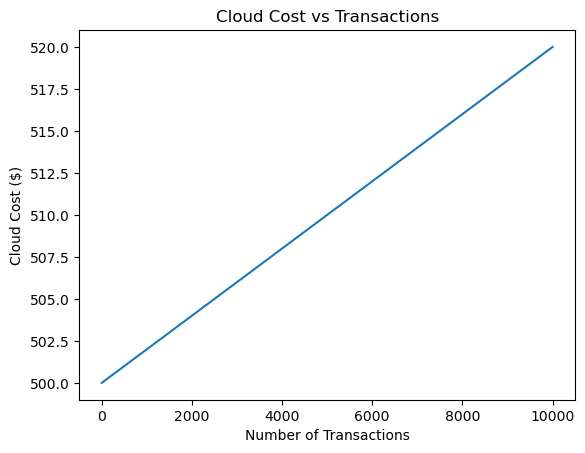

In [6]:
transactions = np.arange(1, 10_001)
cost = 0.002 * transactions + 500  # simple linear cost model

plt.plot(transactions, cost)
plt.xlabel("Number of Transactions")
plt.ylabel("Cloud Cost ($)")
plt.title("Cloud Cost vs Transactions")
plt.show()


## Latency & Scaling (Little’s Law)

\[
L = \lambda W
\]

- L = number of requests in system
- λ = arrival rate
- W = average latency

Banks design systems to meet strict SLAs under peak load.


In [7]:
arrival_rate = np.array([50, 100, 200, 400])  # requests/sec
latency = 0.1  # seconds

L = arrival_rate * latency
L

array([ 5., 10., 20., 40.])

## Explainability & Model Risk Management

Banks require:
- Interpretable features
- Bias testing
- Drift monitoring
- Version control
- Kill switches

Models are treated as **risk assets**, not just code.


In [8]:
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
from sklearn.metrics import accuracy_score

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# -------------------------
#  Simulate dataset
# -------------------------
np.random.seed(42)
X = np.random.normal(0, 1, (1000, 5))
y = np.random.binomial(1, 0.1, 1000)

# -------------------------
#  Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
#  Train model
# -------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# -------------------------
#  Generate production predictions
# -------------------------
prod_predictions = model.predict(X_test)

# -------------------------
#  Bias / Fairness Metrics
# -------------------------
# Simulate sensitive attribute (gender)
np.random.seed(42)
sensitive_attr = np.random.choice(["Male", "Female"], size=len(y_test))

y_pred = prod_predictions
groups = np.unique(sensitive_attr)

for g in groups:
    idx = sensitive_attr == g
    y_true_group = y_test[idx]
    y_pred_group = y_pred[idx]

    # Compute confusion matrix safely
    cm = confusion_matrix(y_true_group, y_pred_group, labels=[0,1])
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2,2) else (0,0,0,0)
    
    # Metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    selection_rate = (tp + fp) / len(y_pred_group) if len(y_pred_group) > 0 else 0

    print(f"{g}: Selection Rate={selection_rate:.2f}, TPR={tpr:.2f}, FPR={fpr:.2f}")


Female: Selection Rate=0.00, TPR=0.00, FPR=0.00
Male: Selection Rate=0.00, TPR=0.00, FPR=0.00


In [10]:
import numpy as np

# -------------------------
#  Define baseline predictions (training reference)
baseline_predictions = model.predict(X_train)  # model trained earlier

#  Simulate production predictions (new incoming data)
prod_predictions = model.predict(X_test)

# -------------------------
#  PSI Calculation Function
# -------------------------
def population_stability_index(expected, actual, buckets=10):
    """
    Calculate Population Stability Index (PSI) between baseline and new predictions/features.
    """
    expected = np.array(expected)
    actual = np.array(actual)

    # Define bin edges based on baseline
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))

    # Count values in each bin
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]

    # Convert counts to percentages
    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)

    # Add small epsilon to avoid division by zero
    epsilon = 1e-6
    psi_values = (actual_perc - expected_perc) * np.log((actual_perc + epsilon) / (expected_perc + epsilon))

    # Sum over all bins
    psi = np.sum(psi_values)
    return psi

# -------------------------
#  Compute PSI
# -------------------------
psi_value = population_stability_index(baseline_predictions, prod_predictions)
print(f"Population Stability Index (PSI): {psi_value:.4f}")

# -------------------------
#  Kill Switch / Drift Alert
# -------------------------
if psi_value > 0.25:
    print(" Significant population shift detected! Trigger Kill Switch: Investigate or retrain model.")
elif psi_value > 0.1:
    print(" Moderate shift detected — monitor closely.")
else:
    print(" Population stable — no action needed.")


Population Stability Index (PSI): 0.0000
 Population stable — no action needed.


In [11]:
# -------------------------
# PII Masking Example
# -------------------------
import pandas as pd

# Simulate a customer dataframe
df = pd.DataFrame({
    "Name": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "SSN": ["123-45-6789", "987-65-4321", "111-22-3333", "444-55-6666", "777-88-9999"],
    "CreditScore": [700, 650, 720, 680, 690]
})

print("Original Data:\n", df)

# Mask SSN (PII)
df["SSN_masked"] = df["SSN"].apply(lambda x: "XXX-XX-" + x.split("-")[2])
print("\nMasked Data:\n", df)

# -------------------------
#  Differential Privacy Example
# -------------------------
# Requires diffprivlib: pip install diffprivlib
from diffprivlib.models import LogisticRegression as DPLogisticRegression

# Simulate DP training (same X, y from before)
dp_model = DPLogisticRegression(epsilon=1.0, data_norm=2.0)
dp_model.fit(X_train, y_train)

dp_predictions = dp_model.predict(X_test)
print("\nDP Model Sample Predictions:", dp_predictions[:5])


Original Data:
       Name          SSN  CreditScore
0    Alice  123-45-6789          700
1      Bob  987-65-4321          650
2  Charlie  111-22-3333          720
3    David  444-55-6666          680
4      Eve  777-88-9999          690

Masked Data:
       Name          SSN  CreditScore   SSN_masked
0    Alice  123-45-6789          700  XXX-XX-6789
1      Bob  987-65-4321          650  XXX-XX-4321
2  Charlie  111-22-3333          720  XXX-XX-3333
3    David  444-55-6666          680  XXX-XX-6666
4      Eve  777-88-9999          690  XXX-XX-9999

DP Model Sample Predictions: [0 0 1 0 0]


## Cloud Platform Awareness

**AWS**
- IAM granularity
- VPC isolation
- SageMaker governance

**Azure**
- Active Directory integration
- Enterprise compliance tooling

**GCP**
- BigQuery + Vertex AI
- Large-scale analytics


**This demonstrates how banks use AI differently, expected loss, fraud tradeoffs, cloud cost modeling, and governance.**

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Simulate dataset (replace with your bank data)
X = np.random.normal(0, 1, (1000, 5))  # 1000 rows, 5 features
y = np.random.binomial(1, 0.1, 1000)   # binary target


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Mild Recession: Mean EL = $1208.37, 95th percentile = $1601.36
Severe Recession: Mean EL = $1510.46, 95th percentile = $2001.70
Depression: Mean EL = $2013.95, 95th percentile = $2668.93


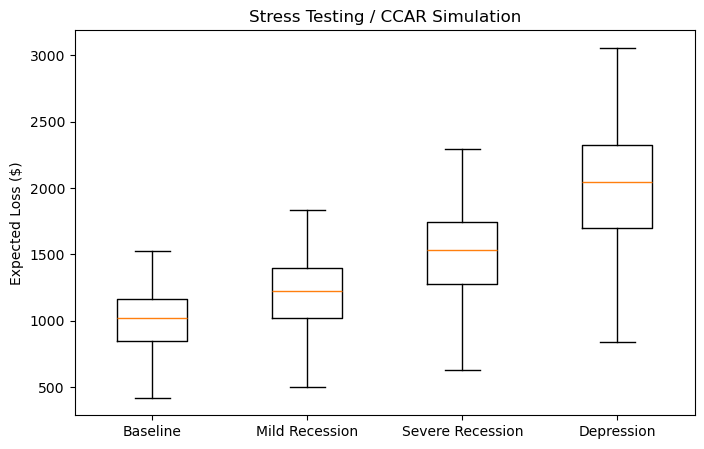

In [16]:
# Baseline expected loss per customer
baseline_EL = np.random.normal(1000, 200, len(X_test))  # X_test must exist

# Stress scenarios
stress_scenarios = {
    "Mild Recession": 1.2,
    "Severe Recession": 1.5,
    "Depression": 2.0
}

# Compute stressed EL
stressed_EL = {k: baseline_EL * v for k, v in stress_scenarios.items()}

# Summary
for scenario, el in stressed_EL.items():
    print(f"{scenario}: Mean EL = ${el.mean():.2f}, 95th percentile = ${np.percentile(el, 95):.2f}")

# Optional: plot
plt.figure(figsize=(8,5))
plt.boxplot([baseline_EL] + list(stressed_EL.values()), labels=["Baseline"] + list(stress_scenarios.keys()))
plt.ylabel("Expected Loss ($)")
plt.title("Stress Testing / CCAR Simulation")
plt.show()


In [17]:
# --- Stress Testing / CCAR Simulation ---
baseline_EL = np.random.normal(1000, 200, len(X_test))  # example expected loss

stress_scenarios = {
    "Mild Recession": 1.2,
    "Severe Recession": 1.5,
    "Depression": 2.0
}

stressed_EL = {k: baseline_EL * v for k, v in stress_scenarios.items()}

for scenario, el in stressed_EL.items():
    print(f"{scenario}: Mean EL = ${el.mean():.2f}, 95th percentile = ${np.percentile(el, 95):.2f}")


Mild Recession: Mean EL = $1192.36, 95th percentile = $1579.82
Severe Recession: Mean EL = $1490.45, 95th percentile = $1974.77
Depression: Mean EL = $1987.27, 95th percentile = $2633.03


In [18]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import shap
import warnings
warnings.filterwarnings("ignore")

# Simulate dataset
X = np.random.normal(0, 1, (1000, 5))  # 1000 rows, 5 features
y = np.random.binomial(1, 0.1, 1000)  # binary target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (must happen BEFORE SHAP or drift)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# SHAP explainability
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Drift Monitoring + Kill Switch
# Baseline predictions (training reference)
baseline_predictions = model.predict(X_train)

# Simulate production predictions
prod_predictions = model.predict(X_test)

# PSI function
def population_stability_index(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, breakpoints)[0]
    actual_counts = np.histogram(actual, breakpoints)[0]
    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)
    psi = np.sum((actual_perc - expected_perc) * np.log((actual_perc + 1e-6) / (expected_perc + 1e-6)))
    return psi

# Compute PSI and prediction drift
psi_value = population_stability_index(baseline_predictions, prod_predictions)
prediction_drift_value = np.abs(np.mean(baseline_predictions) - np.mean(prod_predictions))

print("PSI:", psi_value)
print("Prediction Drift:", prediction_drift_value)

# Kill switch
DRIFT_PSI_THRESHOLD = 0.25
PREDICTION_DRIFT_THRESHOLD = 0.05

class KillSwitch:
    def __init__(self):
        self.enabled = True
        self.audit_log = []
    def disable(self, reason):
        self.enabled = False
        self.audit_log.append({"action": "DISABLE", "reason": reason})
    def enable(self, approved_by):
        if approved_by not in ["Model Risk", "Compliance"]:
            raise PermissionError("Unauthorized reactivation")
        self.enabled = True
        self.audit_log.append({"action": "ENABLE", "approved_by": approved_by})

ks = KillSwitch()
if psi_value >= DRIFT_PSI_THRESHOLD:
    ks.disable("Data drift exceeded PSI threshold")
elif prediction_drift_value >= PREDICTION_DRIFT_THRESHOLD:
    ks.disable("Prediction drift exceeded threshold")

ks.enabled, ks.audit_log



PSI: 0.0
Prediction Drift: 0.0


(True, [])

In [19]:
# ===========================
#  Drift Monitoring + Kill Switch
# ===========================

#  Define baseline predictions (training)
baseline_predictions = model.predict(X_train)

#  Simulate production / new incoming data predictions
prod_predictions = model.predict(X_test)

#  PSI Calculation (Population Stability Index)
def population_stability_index(expected, actual, buckets=10):
    expected = np.array(expected)
    actual = np.array(actual)
    
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]
    
    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)
    
    epsilon = 1e-6
    psi_values = (actual_perc - expected_perc) * np.log((actual_perc + epsilon) / (expected_perc + epsilon))
    return np.sum(psi_values)

psi_value = population_stability_index(baseline_predictions, prod_predictions)
print(f"PSI: {psi_value:.4f}")

#  Optional: simple Kill Switch logic
if psi_value > 0.25:
    print(" Significant population shift detected! Consider retraining the model.")
else:
    print(" Population stable.")


PSI: 0.0000
 Population stable.


## Model Explainability with SHAP

Banks must explain:
- Why a customer was approved or declined
- Which features drove the decision
- Whether the model introduces bias

SHAP (SHapley Additive exPlanations) provides:
- Local explanations (per decision)
- Global explanations (model behavior)
- Regulator-friendly transparency


In [20]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


In [21]:
# Baseline predictions on training data (used for drift monitoring)
baseline_predictions = model.predict(X_train)


In [22]:
# Simulated production data (example)
prod_scores = np.random.normal(640, 70, len(X_test))  # e.g., numeric feature
prod_predictions = model.predict(X_test)  # predictions on test / "production" data


In [23]:
# PSI calculation
psi_value = population_stability_index(baseline_predictions, prod_predictions)

# Prediction drift
prediction_drift_value = np.abs(np.mean(baseline_predictions) - np.mean(prod_predictions))

print("PSI:", psi_value)
print("Prediction Drift:", prediction_drift_value)


PSI: 0.0
Prediction Drift: 0.0


In [24]:
def population_stability_index(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, breakpoints)[0]
    actual_counts = np.histogram(actual, breakpoints)[0]
    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)
    psi = np.sum((actual_perc - expected_perc) * np.log((actual_perc + 1e-6) / (expected_perc + 1e-6)))
    return psi

In [25]:
DRIFT_PSI_THRESHOLD = 0.25
PREDICTION_DRIFT_THRESHOLD = 0.05

class KillSwitch:
    def __init__(self):
        self.enabled = True
        self.audit_log = []
    def disable(self, reason):
        self.enabled = False
        self.audit_log.append({"action": "DISABLE", "reason": reason})
    def enable(self, approved_by):
        if approved_by not in ["Model Risk", "Compliance"]:
            raise PermissionError("Unauthorized reactivation")
        self.enabled = True
        self.audit_log.append({"action": "ENABLE", "approved_by": approved_by})

In [26]:
ks = KillSwitch()

if psi_value >= DRIFT_PSI_THRESHOLD:
    ks.disable("Data drift exceeded PSI threshold")
elif prediction_drift_value >= PREDICTION_DRIFT_THRESHOLD:
    ks.disable("Prediction drift exceeded threshold")

ks.enabled, ks.audit_log

(True, [])

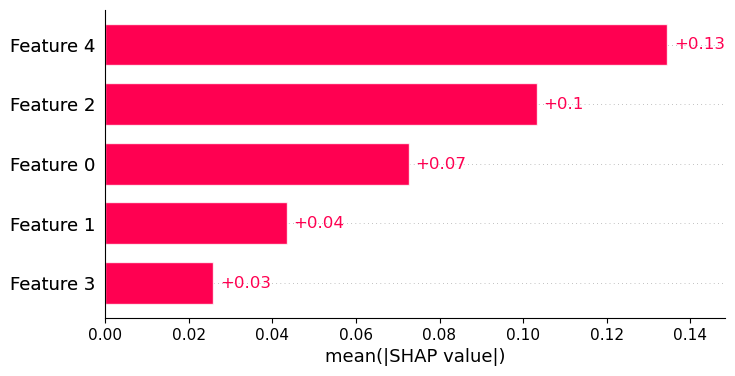

In [27]:
shap.plots.bar(shap_values)

# “This shows global feature importance, which regulators often request during model validation.”

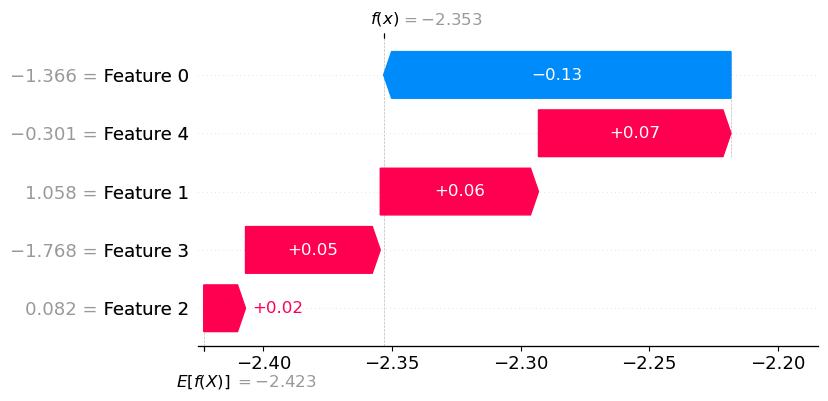

In [28]:
shap.plots.waterfall(shap_values[0])
# This explains an individual credit decision, exactly what’s required for adverse action notices.

## Model Drift Monitoring & Kill Switches

Banks require that models are continuously monitored for:
- Data drift (input features)
- Prediction drift
- Automated disablement (kill switch)

In [29]:
# Drift thresholds
DRIFT_PSI_THRESHOLD = 0.25
PREDICTION_DRIFT_THRESHOLD = 0.05

# Kill switch class
class KillSwitch:
    def __init__(self):
        self.enabled = True
        self.audit_log = []
    def disable(self, reason):
        self.enabled = False
        self.audit_log.append({"action": "DISABLE", "reason": reason})
    def enable(self, approved_by):
        if approved_by not in ["Model Risk", "Compliance"]:
            raise PermissionError("Unauthorized reactivation")
        self.enabled = True
        self.audit_log.append({"action": "ENABLE", "approved_by": approved_by})




## AWS Regulated AI Architecture (Banking)

```mermaid
flowchart LR
    U["Customer / Banker Apps"]
    AG["Amazon API Gateway"]
    VPC["AWS VPC - Private Subnets"]
    SM["Amazon SageMaker Endpoint"]
    FS["SageMaker Feature Store"]
    S3["Amazon S3 Data Lake"]
    KMS["AWS KMS"]
    CW["CloudWatch Logs"]
    CT["AWS CloudTrail"]

    U --> AG
    AG --> VPC
    VPC --> SM
    SM --> FS
    FS --> S3
    S3 --> KMS
    SM --> CW
    AG --> CT
```


 
---

**Why banks prefer AWS.**

-Fine-grained IAM

-VPC isolation

-Mature ML governance

**“Inference happens inside a private VPC with full auditability.”**

   


#### Inference runs inside private subnets, data is encrypted with KMS, and all activity is logged for auditability.

## Azure Regulated AI Architecture (Banking)

```mermaid
flowchart LR
    U["Customer / Banker Apps"]
    APIM["Azure API Management"]
    VNET["Azure Virtual Network"]
    AML["Azure Machine Learning Endpoint"]
    ADLS["Azure Data Lake Storage Gen2"]
    KV["Azure Key Vault"]
    AAD["Azure Active Directory"]
    MON["Azure Monitor"]
    PUR["Microsoft Purview"]

    U --> APIM
    APIM --> VNET
    VNET --> AML
    AML --> ADLS
    ADLS --> KV
    APIM --> AAD
    AML --> MON
    ADLS --> PUR
```




## Governance Overlay

**Governance & Model Risk Controls**

Applies to all cloud platforms:
- Encryption at rest and in transit
- Least-privilege IAM
- Model versioning
- Drift detection
- Manual approval gates
- Kill switches

Models are treated as **regulated risk assets**.

#### I built a Jupyter notebook showing how banks use AI responsibly, expected loss, fraud tradeoffs, cloud cost modeling, SHAP explainability, and secure AWS/Azure/GCP architectures. It reflects how models are validated, governed, and deployed in real banks.

## Azure Regulated AI Architecture (Banking)

```mermaid
flowchart LR
    U["Customer / Banker Apps"]
    APIM["Azure API Management"]
    VNET["Azure Virtual Network"]
    AML["Azure Machine Learning Endpoint"]
    ADLS["Azure Data Lake Storage Gen2"]
    KV["Azure Key Vault"]
    AAD["Azure Active Directory"]
    MON["Azure Monitor"]
    PUR["Microsoft Purview"]

    U --> APIM
    APIM --> VNET
    VNET --> AML
    AML --> ADLS
    ADLS --> KV
    APIM --> AAD
    AML --> MON
    ADLS --> PUR
```


### Azure’s strength is identity-first governance using Active Directory and Purview.

#### Governance is cloud-agnostic — controls are consistent across AWS, Azure, and GCP.